# Expérience basique
## Obtenir les bandes passantes mémoire et disque en séquentielle et aléatoire
### Description
Le but de cette expérience est d'obtenir les bandes passantes de la mémoire et du disque en séquentielle et aléatoire.

Le benchmark `filebench` sera donc utilisé avec les charge de travail `filemicro_seqread`, `filemicro_randread`, `filemicro_seqread_directio` et `filemicro_randread_directio` pour un fichier de 2048MB avec une granularité de 1MB.

Afin de faire la différence entre les accès disques et les accès mémoires l'option `directio` de `filebench` a été utilisée. Cette option permet de court-circuiter le cache du système de fichier.

### Environnement
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs. Les conteneurs n'ont pas été limités au niveau de la mémoire.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

### L'option directio
L'option `directio` de `filebench` indique à celui qu'il doit ouvrir les fichiers en renseignant l'attribut `O_DIRECT`. D'après la page de manuel de la fonction `open`, cet attribut essaye « *de minimiser les effets du cache d'entrée-sortie sur ce fichier* ».

Puis que cette option minimise seulement les effets du cache d'entrée-sortie il est possible que certains accès aient lieu dans le cache. Dans les cas où l'option est activée la bande passante obtenue ne sera pas exactement la bande passante disque mais plutôt une approximation.

Une note assez intéressante peut aussi être trouvée dans cette page de manuel au sujet de cet attribut :
« *Ce qui m'a toujours dérangé avec O_DIRECT est que toute l'interface est stupide et a probablement été conçue par un singe dérangé, sous l'influence de substances psychotropes puissantes.* » — Linus.

### filemicro_randread
La charge de travail `filemicro_randread` ne fait pas parti de `filebench`. Néanmoins elle est identique à `filemicro_seqread` sauf que les lectures sont effectuées aléatoirement.

Son code est le suivant :
```
set $dir=/tmp
set $cached=false
set $filesize=2g
set $iosize=1m
set $nthreads=1

define file name=largefile,path=$dir,size=$filesize,prealloc,reuse,cached=$cached

define process name=filereader,instances=1
{
  thread name=filereaderthread,memsize=10m,instances=$nthreads
  {
    flowop read random,name=seqread-file,filename=largefile,iosize=$iosize
  }
}

echo  "FileMicro-RandRead Version 2.1 personality successfully loaded"
usage "Usage: set \$dir=<dir>"
usage "       set \$cached=<bool>    defaults to $cached"
usage "       set \$filesize=<size>  defaults to $filesize"
usage "       set \$iosize=<size>    defaults to $iosize"
usage "       set \$nthreads=<value> defaults to $nthreads"
usage " "
usage "       run runtime (e.g. run 60)"

run 30
```

### Résultats attendus
Dans le cas où les lectures profitent du cache de fichier les accès auront lieu dans la mémoire donc le nombre d'opérations par seconde multiplié par la granularité d'une opération (ici 1MB) nous donnera la bande passante de la mémoire (en MB/s).

Tandis que quand lorsque l'option `directio` est activée les accès se feront depuis le disque donc nous obtiendrons la bande passante disque.

Les différentes charges de travail sont exécutées dans `/tmp` qui appartient à un volume ayant pour système de fichier `ext4fs`.

### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Le script de l'expérience est le suivant :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
import sys
import docker
import os
import threading
import json

"""This python script will start a container with filebench..

It will then run 10 times the wml_file given as argument. The output of
filebench will be written to a file and statistics (memory usage in bytes and
reads from the disk) will be written to another file.
"""

def main():
	if len(sys.argv) != 2:
		sys.exit("Usage: %s wml_file" % sys.argv[0])

	client = docker.from_env()

	# Launch container as detached.
	container = client.containers.run('filebench', auto_remove = True, detach = True)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	# Write have to be done directly to this file to trigger the cache
	# dropping so they can not be buffered.
	# The drawback of unbuffered I/O is that it is impossible to write
	# string but it is still possible to write bytes (this is the why of
	# 'b' in the mode).
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run the benchmark once so its files will be prepared for the next times.
	container.exec_run('./filebench -f workloads/%s' % sys.argv[1])

	# Drop the cache so the runs above does not have a consequence on the runs
	# below. It can be a good idea to separate our filebench experiment in two WSL
	# files: one for preparing the run (by creating file) and the other to
	# effectively run the benchmark.
	drop_cache.write(bytearray('3\n', 'utf-8'))

	out = open(os.path.expanduser('~/%s.out' % sys.argv[1]), 'w')

	stats = open(os.path.expanduser('~/%s.stats' % sys.argv[1]), 'w')

	stats.write('iteration;usage;reads\n')

	# Run the filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		gen = container.stats()

		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run('./filebench -f workloads/%s' % sys.argv[1])[1].decode('utf-8') + '\n')

		statistics = []
		old_read = 0

		for record in gen:
			# Translate the record in string and translate it to python dictionary.
			# Vive la Joz' ! Bon vivant Docteur bon vivant !
			jason = json.loads(record.decode('utf-8'))

			# Create a new dictionary at each iteration so the statistics's cases are
			# differents.
			chicandier = {'usage': jason['memory_stats']['usage']}

			for io in jason['blkio_stats']['io_serviced_recursive']:
				if io['op'] == 'Read':
					# Get the difference between this iteration and the previous one.
					# The value is so the number of read for this second. It can be seen
					# as the bandwith.
					val = io['value'] - old_read

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_read = io['value']

					# Little trick if the key is not already present.
					if 'reads' in chicandier:
						chicandier['reads'] += val
					else:
						chicandier['reads'] = val

			statistics.append(chicandier)

			# Our filebenches last 30 seconds so we just want 30 records since
			# containerd give stats every second.
			if len(statistics) == 30:
				break

		# Add the statistics to the stat file.
		for i in range(len(statistics)):
			stats.write('%d;%d;%d\n' % (i, statistics[i]['usage'], \
				statistics[i]['reads']))

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	container.stop()

	out.close()

	stats.close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ce script a ensuite été exécuté avec comme argument les charges de travail suivantes : `filemicro_seqread`, `filemicro_randread`, `filemicro_seqread_directio` et `filemicro_randread_directio`.

### Résultats obtenus
Puisque les accès ont une granularité de 1MB alors le nombre d'opérations par seconde est égal à la bande passante en MB/s.
Le graphique suivant montre les résultats obtenus :

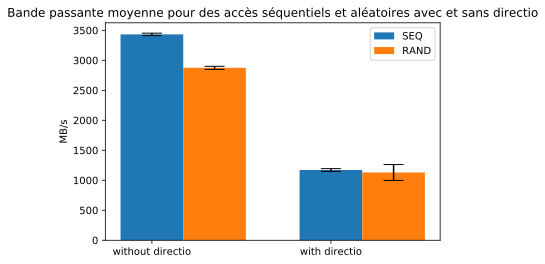

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

seq_means = []
seq_stds = []

rand_means = []
rand_stds = []

for file in ['filemicro_seqread/filemicro_seqread.f.out.csv', 'filemicro_seqread_directio/filemicro_seqread_directio.f.out.csv']:
    df = pd.read_csv(file, ';')
    values = df.values

    seq_means.append(values.mean(0)[1])
    seq_stds.append(values.std(0)[1])
    
for file in ['filemicro_randread/filemicro_randread.f.out.csv', 'filemicro_randread_directio/filemicro_randread_directio.f.out.csv']:
    df = pd.read_csv(file, ';')
    values = df.values

    rand_means.append(values.mean(0)[1])
    rand_stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
NAMES = ['without directio', 'with directio']
x_pos = np.arange(len(NAMES))

# Axis and figure initialization.
fig, ax = plt.subplots()
WIDTH = .35
group0 = ax.bar(x_pos, seq_means, WIDTH, yerr = seq_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
group1 = ax.bar(x_pos + WIDTH, rand_means, WIDTH, yerr = rand_stds, align = 'center', capsize = 10)
ax.set_ylabel('MB/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(NAMES)
ax.legend((group0[0], group1[0]), ('SEQ', 'RAND'))
ax.set_title("Bande passante moyenne pour des accès séquentiels et aléatoires avec et sans directio")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les écart-types sont faibles donc les résultats sont plutôt stables.

Les accès aléatoires sont un peu plus lents que les accès séquentiels. L'utilisation de l'option `directio` de `filebench` ruine les performances car les accès ne peuvent plus compter sur le cache du système de fichier.

### Conclusion
Avec `directio` la bande passante est d'environ 1GB/s tandis qu'elle est de 3-3.5GB/s sans.